In [1]:
import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split,StratifiedKFold,KFold,learning_curve,validation_curve
from sklearn import metrics
from sklearn.metrics import mean_squared_error,accuracy_score,confusion_matrix, roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from scipy import stats
from libtsvm.estimators import TSVM
from libtsvm.model_selection import Validator, grid_search
from libtsvm.preprocess import DataReader

In [2]:
df = pd.read_csv("bt_dataset_t3.csv")
print(df.describe())
print(df.shape)

             Class         Mean     Variance  Standard Deviation      Entropy  \
count  7912.000000  7912.000000  7912.000000         7912.000000  7912.000000   
mean      0.494944     9.421721   719.703482           25.186816     0.070723   
std       0.500006     5.973474   485.486996            9.237888     0.073660   
min       0.000000     0.031006     1.773896            1.331877     0.000763   
25%       0.000000     4.814888   352.472987           18.774264     0.005260   
50%       0.000000     8.363800   636.717144           25.233255     0.057492   
75%       1.000000    13.488964  1002.650852           31.664663     0.111447   
max       1.000000    32.974335  2910.581879           53.949809     0.599728   

          Skewness     Kurtosis     Contrast       Energy          ASM  \
count  7912.000000  7912.000000  7912.000000  7912.000000  7912.000000   
mean      4.405060    31.261144   129.807348     0.196732     0.056486   
std       3.274796    86.984261   107.569432    

In [3]:
df.head()
print(df.shape)

(7912, 19)


In [4]:
df = df.replace([np.inf, -np.inf], np.nan)
df = df.fillna(df.mean())
df = df.drop(['Image','PSNR','SSIM','DC','Coarseness','TS'], axis=1)
# df = df.drop(['Image','Coarseness'], axis=1)
df['Class'] = df['Class'].replace(to_replace =0,value =-1) 


In [5]:
z = np.abs(stats.zscore(df))
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
df = df[(z < 2.1).all(axis=1)]
df = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]
df.shape

(6012, 13)

In [6]:
y = df['Class']
X = df.drop(['Class'], axis=1)
np.sum(df['Class']==-1)

3373

In [7]:
df.to_csv('final_data.csv', index=False)

df.head()

,Class,Mean,Variance,Standard Deviation,Entropy,Skewness,Kurtosis,Contrast,Energy,ASM,Homogeneity,Dissimilarity,Correlation
1,1,16.376648,1666.027096,40.816995,0.001810,3.270831,11.744579,127.107214,0.035536,0.001263,0.315807,6.406097,0.972815
2,1,7.341095,1143.808219,33.820234,0.001467,5.061750,26.479563,81.867206,0.031917,0.001019,0.268275,5.981800,0.978014
3,1,7.265640,1135.230082,33.693176,0.001167,5.069645,26.494927,104.731966,0.028452,0.000810,0.219702,6.757949,0.970221
4,1,5.958145,959.711985,30.979219,0.001477,5.677977,33.428845,151.229741,0.032024,0.001026,0.243851,7.700919,0.964189
5,-1,7.524109,607.395258,24.645390,0.214086,3.729886,14.471736,105.077882,0.421587,0.177736,0.598169,4.193146,0.976485


###### Split data into train and test

In [8]:
X_train, X_test,  y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [9]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5),TN=None,FP=None,TP=None,FN=None,mse=None,AC = None,F1=None,SE=None,SP=None,PR=None,BER=None,TA=None,fname=None):
   
    if axes is None:
        fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(20, 10))
        

    
    start = time.time() 
    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,scoring='neg_mean_squared_error',
                       return_times=True)
    TT = time.time()-start
    
    train_scores_mean = -np.mean(train_scores, axis=1)
    train_scores_std = -np.std(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)
    test_scores_std = -np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)
    
    a = fname.split()
    if a[0] == 'SVM' or a[0]=='Twin':
        param_range = np.logspace(-5, 0, 5)
        train_scoresv, test_scoresv = validation_curve(estimator, X, y, param_name="gamma", param_range=param_range,scoring="accuracy", cv=5)
    else:
        param_range = np.arange(1, 500, 5)
        train_scoresv, test_scoresv = validation_curve(estimator, X, y, param_name="n_estimators", param_range=param_range,scoring="accuracy", cv=5)
        
    train_scores_meanv = np.mean(train_scoresv, axis=1)
    train_scores_stdv = np.std(train_scoresv, axis=1)
    test_scores_meanv = np.mean(test_scoresv, axis=1)
    test_scores_stdv = np.std(test_scoresv, axis=1)
    
    print(total_time)
    print(fit_times_mean)
    print(train_scores_mean)
    print(test_scores_mean)
    avg_train = np.mean(train_scores_mean)
    avg_test = np.mean(test_scores_mean)
    if not os.path.exists('result.csv'):
        columns = ['Model','TN','FP','FN','TP','Accuracy','Sensitivity','Specificity','Precision','F1_Score','MSE','Error Rate','Training Accuracy','Time']
        df = pd.DataFrame(columns = columns)
        lst = pd.Series({'Model':fname,'TN':TN,'FP':FP,'FN':FN,'TP':TP,'Accuracy':AC,
                         'Sensitivity':SE,'Specificity':SP,'Precision':PR,'F1_Score':F1,
                         'MSE':mse,'Error Rate':BER,'Training Accuracy':TA,'Time':TT})

        df = df.append(lst, ignore_index=True)
        df.to_csv('result.csv',index=False)
    else:
        df = pd.read_csv('result.csv')
        lst = pd.Series({'Model':fname,'TN':TN,'FP':FP,'FN':FN,'TP':TP,'Accuracy':AC,
                         'Sensitivity':SE,'Specificity':SP,'Precision':PR,'F1_Score':F1,
                         'MSE':mse,'Error Rate':BER,'Training Accuracy':TA,'Time':TT})
        df = df.append(lst, ignore_index=True)
        df.to_csv('result.csv',index=False)


    # Plot learning curve
    ax1.grid()
    ax1.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    ax1.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    ax1.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training error")
    ax1.plot(train_sizes, test_scores_mean, 'o-', color="b",
                 label="Cross Validation error")
    ax1.legend(loc="best")
    ax1.set_title(title)
    ax1.set_xlabel("Training set size")
    ax1.set_ylabel("MSE")

    # validation curve
    lw = 2
    ax2.grid()
    ax2.semilogx(param_range, train_scores_meanv, label="Training score",
             color="darkorange", lw=lw)
    ax2.fill_between(param_range, train_scores_meanv - train_scores_stdv,
                     train_scores_meanv + train_scores_stdv, alpha=0.2,
                     color="darkorange", lw=lw)
    ax2.semilogx(param_range, test_scores_meanv, label="Cross-validation score",
                 color="navy", lw=lw)
    ax2.fill_between(param_range, test_scores_meanv - test_scores_stdv,
                     test_scores_meanv + test_scores_stdv, alpha=0.2,
                     color="navy", lw=lw)
    
    ax2.set_xlabel("Training set size")
    ax2.set_ylabel("Score")
    ax2.set_title("Validation Curve")
    ax2.legend(loc="best")
    
    
     # Plot n_samples vs fit_times
    ax3.grid()
    ax3.plot(train_sizes, fit_times_mean, 'o-')
    ax3.fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    ax3.set_xlabel("Training examples")
    ax3.set_ylabel("fit_times")
    ax3.set_title("Scalability of the model")

    # Plot fit_time vs score
    ax4.grid()
    ax4.plot(fit_times_mean, test_scores_mean, 'o-')
    ax4.fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    ax4.set_xlabel("fit_times")
    ax4.set_ylabel("Error")
    ax4.set_title("Performance of the model")


    fig.savefig(fname+".png")
    
    return plt

In [10]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

###### SVM with 5 fold

In [11]:
steps = [('clf',SVC(kernel='rbf'))]
parameters = {
    'clf__C':[0.001,0.1,10,10e5],
    'clf__gamma':[0.1,0.01,0.001]
}
pipeline = Pipeline(steps)

In [12]:
cv=5
grid = GridSearchCV(pipeline,param_grid=parameters,cv=cv)
grid.fit(X_train,y_train)
parm = grid.best_params_
print("Score for %d fold : = %f"%(cv,grid.score(X_test,y_test)))
print("Parameters : ",parm)

Score for 5 fold : = 0.992794
Parameters :  {'clf__C': 1000000.0, 'clf__gamma': 0.001}


In [13]:
cv = 5
start = time.time() 
clf = SVC(kernel='rbf', gamma=parm['clf__gamma'],C=parm['clf__C'],probability=True)
clf.fit(X_train,y_train)
y_pred_test= clf.predict(X_test)
total_time = time.time()-start

y_pred_train= clf.predict(X_train)

In [14]:
mse =mean_squared_error(y_test, y_pred_test)
Train_Accuracy = accuracy_score(y_train, y_pred_train)
print('Train Accuracy',Train_Accuracy)
print('Test Accuracy',accuracy_score(y_test, y_pred_test))
print('Total Time : ',total_time)
print('MSE: ',mse)



Train Accuracy 0.9952471482889734
Test Accuracy 0.9927937915742794
Total Time :  7.635338306427002
MSE:  0.028824833702882482


In [15]:
TN, FP, FN, TP = confusion_matrix(y_test,y_pred_test).ravel()
print(TN, FP, FN, TP)
SE = TP/(TP+FN)  #sensitivity, recall, hit rate, or true positive rate (TPR)
SP = TN/(TN+FP)  #specificity, selectivity or true negative rate (TNR)
AC = (TP+TN)/(TP+TN+FP+FN)   #accuracy
PR = TP/(TP+FP)   #precision, positive predictive value (PPV)
BCR = 1/2*(SE+SP)   #balanced classification rate
BER = 1-BCR   #balanced error rate
F1 = 2*PR*SE/(PR+SE)   #F1 score
FNR = 1-SE   #miss rate or false negative rate (FNR)
FPR = 1-SP   #fall-out or false positive rate (FPR)
TS = TP/(TP+FP+FN)   #Threat score (TS) or Critical Success Index (CSI)
DC = 2*TP/(2*TP+FP+FN) #Dice Coefficient
print(AC,F1,TS,DC)

1008 1 12 783
0.9927937915742794 0.9917669411019633 0.9836683417085427 0.9917669411019633


7.635338306427002
[0.0208806  0.70514712 1.53732333 2.61567683 5.3576406 ]
[-0.          0.0095151   0.01426256  0.01564417  0.01996435]
[0.12072835 0.07224292 0.05513061 0.0456283  0.0370761 ]


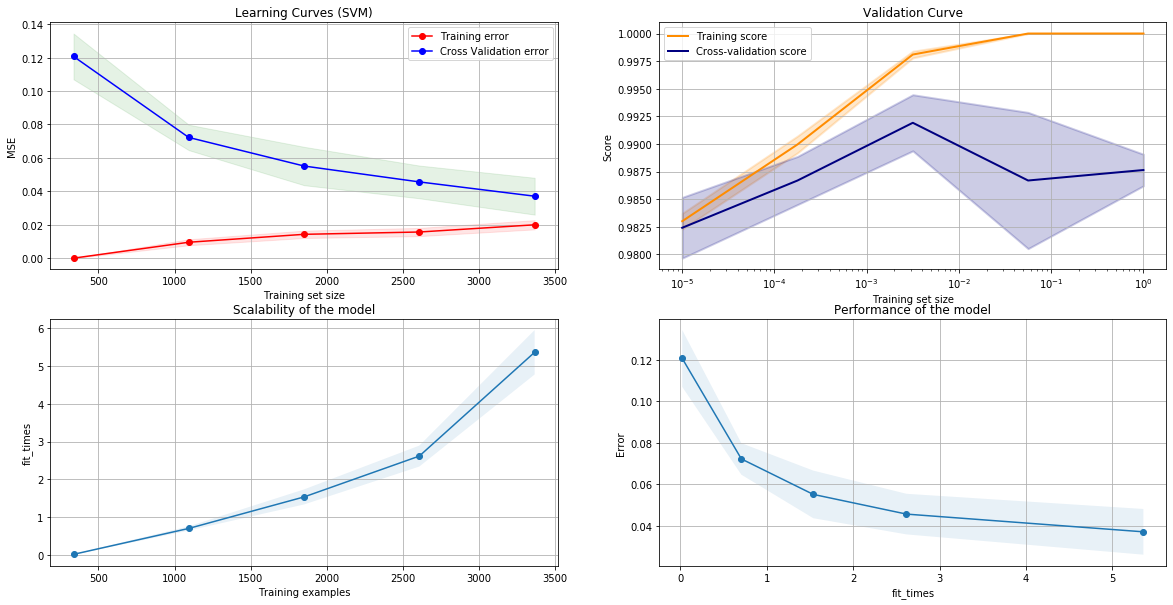

In [16]:
title = r"Learning Curves (SVM)"
fname = "SVM"
plot_learning_curve(clf, title, X_train, y_train,
                    cv=cv, TN=TN,FP=FP,TP=TP,FN=FN,mse=mse,AC = AC,F1=F1,SE=SE,SP=SP,PR=PR,BER=BER,TA=Train_Accuracy,fname=fname)

plt.show()

###### PCA + SVM with 5 folds

In [17]:
steps = [('pca',PCA()),('clf',SVC(kernel='rbf'))]
parameters = {
    'pca__n_components' :[2,3,4],
    'clf__C':[0.001,0.1,10,100,10e5],
    'clf__gamma':[1,0.1,0.01,0.001]
}
pipeline = Pipeline(steps)

In [18]:
cv=5
grid = GridSearchCV(pipeline,param_grid=parameters,cv=cv)
grid.fit(X_train,y_train)
parm = grid.best_params_
print("Score for %d fold : = %f"%(cv,grid.score(X_test,y_test)))
print("Parameters : ",parm)

Score for 5 fold : = 0.984479
Parameters :  {'clf__C': 100, 'clf__gamma': 0.1, 'pca__n_components': 4}


In [19]:
pca = PCA(n_components= parm['pca__n_components']) 
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
start = time.time() 
clf1 = SVC(kernel="rbf", gamma=parm['clf__gamma'], C=parm['clf__C'], probability=True)
clf1.fit(X_train,y_train)
y_pred_test= clf1.predict(X_test)
total_time = time.time()-start# # for cv in tqdm(range(4,6)):# # for cv in tqdm(range(4,6)):# # for cv in tqdm(range(4,6)):

y_pred_train= clf1.predict(X_train)

In [20]:
mse = mean_squared_error(y_test, y_pred_test)
Train_Accuracy = accuracy_score(y_train, y_pred_train)
print('Train Accuracy',Train_Accuracy)
print('Test Accuracy',accuracy_score(y_test, y_pred_test))
print('Total Time : ',total_time)
print('MSE: ',mean_squared_error(y_test, y_pred_test))



Train Accuracy 0.9866920152091255
Test Accuracy 0.9844789356984479
Total Time :  0.4824519157409668
MSE:  0.06208425720620843


In [21]:
TN, FP, FN, TP = confusion_matrix(y_test,y_pred_test).ravel()
print(TN, FP, FN, TP)
SE = TP/(TP+FN)  #sensitivity, recall, hit rate, or true positive rate (TPR)
SP = TN/(TN+FP)  #specificity, selectivity or true negative rate (TNR)
AC = (TP+TN)/(TP+TN+FP+FN)   #accuracy
PR = TP/(TP+FP)   #precision, positive predictive value (PPV)
BCR = 1/2*(SE+SP)   #balanced classification rate
BER = 1-BCR   #balanced error rate
F1 = 2*PR*SE/(PR+SE)   #F1 score
FNR = 1-SE   #miss rate or false negative rate (FNR)
FPR = 1-SP   #fall-out or false positive rate (FPR)
TS = TP/(TP+FP+FN)   #Threat score (TS) or Critical Success Index (CSI)
DC = 2*TP/(2*TP+FP+FN) #Dice Coefficient
print(AC,F1,TS,DC)

1003 6 22 773
0.9844789356984479 0.9822109275730623 0.9650436953807741 0.9822109275730623


0.4824519157409668
[0.00626292 0.05198174 0.10961761 0.17933135 0.28616481]
[0.01904762 0.05343092 0.04970286 0.04907975 0.05204991]
[0.12926812 0.09125207 0.07319304 0.07224179 0.06463745]


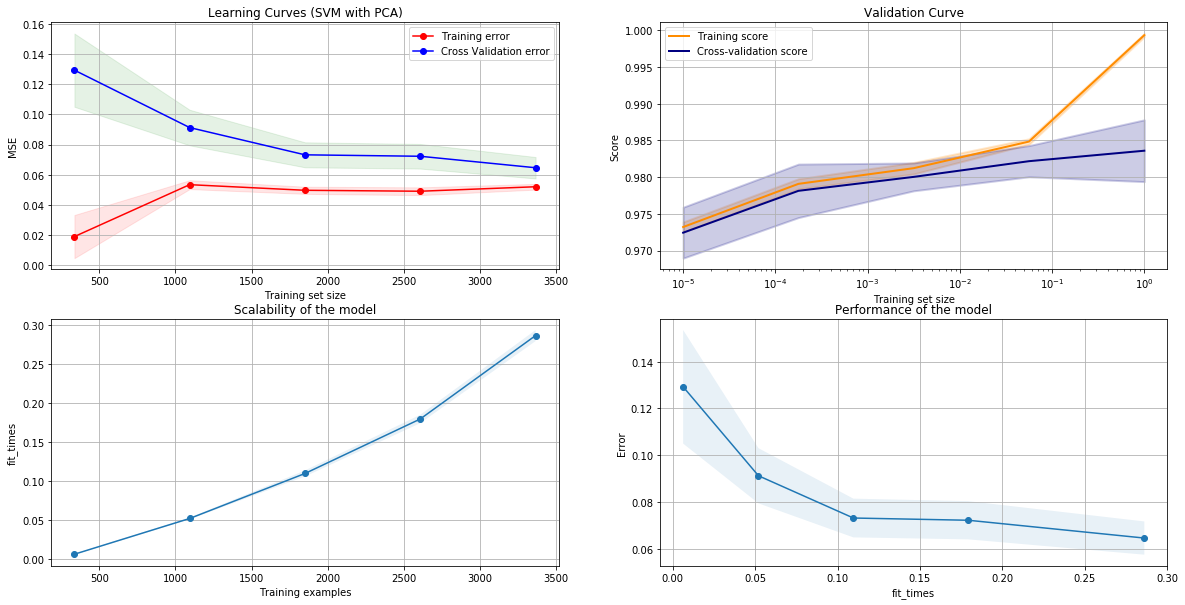

In [22]:
title = r"Learning Curves (SVM with PCA)"
fname = "SVM with PCA"
plot_learning_curve(clf1, title, X_train, y_train,  ylim=(0.7, 1.01),cv=5, TN=TN,FP=FP,TP=TP,FN=FN,mse=mse,AC = AC,F1=F1,SE=SE,SP=SP,PR=PR,BER=BER,TA=Train_Accuracy,fname=fname)

plt.show()

#### Gradient Boosting

In [23]:
steps = [('clf2',GradientBoostingClassifier())]

param_grid={'clf2__n_estimators':[10,100,1000], 
            'clf2__learning_rate': [0.1,1, 0.001, 0.01], 
            'clf2__max_depth':[3,4,5,6], 
            'clf2__min_samples_leaf':[3,5], 
            'clf2__max_features':[1.0] 
           } 
n_jobs=4 
pipeline = Pipeline(steps)

In [24]:
cv=5
grid = GridSearchCV(pipeline,param_grid=param_grid,cv=cv)
grid.fit(X_train,y_train)
parm = grid.best_params_
print("Score for %d fold : = %f"%(cv,grid.score(X_test,y_test)))
print("Parameters : ",parm)

Score for 5 fold : = 0.982816
Parameters :  {'clf2__learning_rate': 0.01, 'clf2__max_depth': 6, 'clf2__max_features': 1.0, 'clf2__min_samples_leaf': 3, 'clf2__n_estimators': 1000}


In [25]:
start = time.time() 
clf2 = GradientBoostingClassifier(learning_rate =parm['clf2__learning_rate'], max_depth=parm['clf2__max_depth'], max_features=parm['clf2__max_features'], min_samples_leaf=parm['clf2__min_samples_leaf'],n_estimators=parm['clf2__n_estimators'],random_state=0)
clf2.fit(X_train, y_train)
y_pred_test = clf2.predict(X_test)
total_time = time.time()-start

y_pred_train = clf2.predict(X_train)

mse = mean_squared_error(y_test, y_pred_test)
Train_Accuracy = accuracy_score(y_train, y_pred_train)
print('Train Accuracy',Train_Accuracy)
print('Test Accuracy',accuracy_score(y_test, y_pred_test))
print('Total Time : ',total_time)
print('MSE: ',mean_squared_error(y_test, y_pred_test))



Train Accuracy 1.0
Test Accuracy 0.9828159645232816
Total Time :  10.928755521774292
MSE:  0.06873614190687362


In [26]:
TN, FP, FN, TP = confusion_matrix(y_test,y_pred_test).ravel()
print(TN, FP, FN, TP)
SE = TP/(TP+FN)  #sensitivity, recall, hit rate, or true positive rate (TPR)
SP = TN/(TN+FP)  #specificity, selectivity or true negative rate (TNR)
AC = (TP+TN)/(TP+TN+FP+FN)   #accuracy
PR = TP/(TP+FP)   #precision, positive predictive value (PPV)
BCR = 1/2*(SE+SP)   #balanced classification rate
BER = 1-BCR   #balanced error rate
F1 = 2*PR*SE/(PR+SE)   #F1 score
FNR = 1-SE   #miss rate or false negative rate (FNR)
FPR = 1-SP   #fall-out or false positive rate (FPR)
TS = TP/(TP+FP+FN)   #Threat score (TS) or Critical Success Index (CSI)
DC = 2*TP/(2*TP+FP+FN) #Dice Coefficient
print(AC,F1,TS,DC)

1001 8 23 772
0.9828159645232816 0.9803174603174604 0.9613947696139477 0.9803174603174604


10.928755521774292
[1.16848407 2.99171972 4.77198462 6.68845897 8.76520939]
[-0. -0. -0. -0. -0.]
[0.16349951 0.09980314 0.08744595 0.079845   0.06938917]


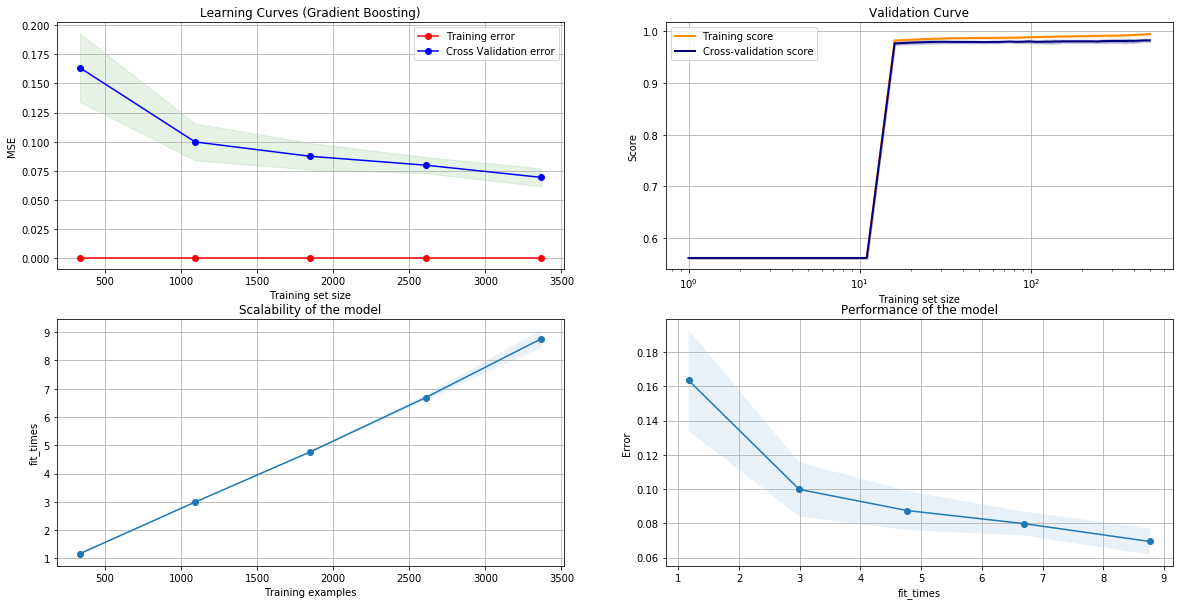

In [27]:
title = r"Learning Curves (Gradient Boosting)"
fname = "Gradient Boosting"
plot_learning_curve(clf2, title, X_train, y_train,  ylim=(0.7, 1.01),cv=5, TN=TN,FP=FP,TP=TP,FN=FN,mse=mse,AC = AC,F1=F1,SE=SE,SP=SP,PR=PR,BER=BER,TA=Train_Accuracy,fname=fname)

plt.show()

#### Gradient Boosting with PCA


In [28]:
steps = [('pca',PCA()),('clf3',GradientBoostingClassifier())]

param_grid={'pca__n_components' :[2,3,4],
            'clf3__n_estimators':[10,100,1000], 
            'clf3__learning_rate': [0.1,1, 0.001, 0.01], 
            'clf3__max_depth':[3,4,5,6], 
            'clf3__min_samples_leaf':[3,5], 
            'clf3__max_features':[1.0] 
           } 
n_jobs=4 
pipeline = Pipeline(steps)

In [29]:
cv=5
grid = GridSearchCV(pipeline,param_grid=param_grid, cv=cv)
grid.fit(X_train,y_train)
parm = grid.best_params_
print("Score for %d fold : = %f"%(cv,grid.score(X_test,y_test)))
print("Parameters : ",parm)

Score for 5 fold : = 0.983370
Parameters :  {'clf3__learning_rate': 0.1, 'clf3__max_depth': 6, 'clf3__max_features': 1.0, 'clf3__min_samples_leaf': 5, 'clf3__n_estimators': 100, 'pca__n_components': 4}


In [30]:
pca = PCA(n_components= parm['pca__n_components']) 
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
start = time.time() 
clf3 = GradientBoostingClassifier(learning_rate =parm['clf3__learning_rate'], max_depth=parm['clf3__max_depth'], max_features=parm['clf3__max_features'], min_samples_leaf=parm['clf3__min_samples_leaf'],n_estimators=parm['clf3__n_estimators'],random_state=0)
clf3.fit(X_train,y_train)
y_pred_test= clf3.predict(X_test)
total_time = time.time()-start

y_pred_train= clf3.predict(X_train)

In [31]:
mse = mean_squared_error(y_test, y_pred_test)
Train_Accuracy = accuracy_score(y_train, y_pred_train)
print('Train Accuracy',Train_Accuracy)
print('Test Accuracy',accuracy_score(y_test, y_pred_test))
print('Total Time : ',total_time)
print('MSE: ',mean_squared_error(y_test, y_pred_test))


Train Accuracy 0.9995247148288974
Test Accuracy 0.9844789356984479
Total Time :  1.1021881103515625
MSE:  0.06208425720620843


In [32]:
TN, FP, FN, TP = confusion_matrix(y_test,y_pred_test).ravel()
print(TN, FP, FN, TP)
SE = TP/(TP+FN)  #sensitivity, recall, hit rate, or true positive rate (TPR)
SP = TN/(TN+FP)  #specificity, selectivity or true negative rate (TNR)
AC = (TP+TN)/(TP+TN+FP+FN)   #accuracy
PR = TP/(TP+FP)   #precision, positive predictive value (PPV)
BCR = 1/2*(SE+SP)   #balanced classification rate
BER = 1-BCR   #balanced error rate
F1 = 2*PR*SE/(PR+SE)   #F1 score
FNR = 1-SE   #miss rate or false negative rate (FNR)
FPR = 1-SP   #fall-out or false positive rate (FPR)
TS = TP/(TP+FP+FN)   #Threat score (TS) or Critical Success Index (CSI)
DC = 2*TP/(2*TP+FP+FN) #Dice Coefficient
print(AC,F1,TS,DC)

1001 8 20 775
0.9844789356984479 0.9822560202788339 0.9651307596513076 0.982256020278834


1.1021881103515625
[0.12274632 0.30135593 0.48691301 0.67514586 0.87239661]
[-0.         -0.         -0.         -0.          0.00071301]
[0.14543709 0.0998054  0.09124755 0.07509553 0.07224179]


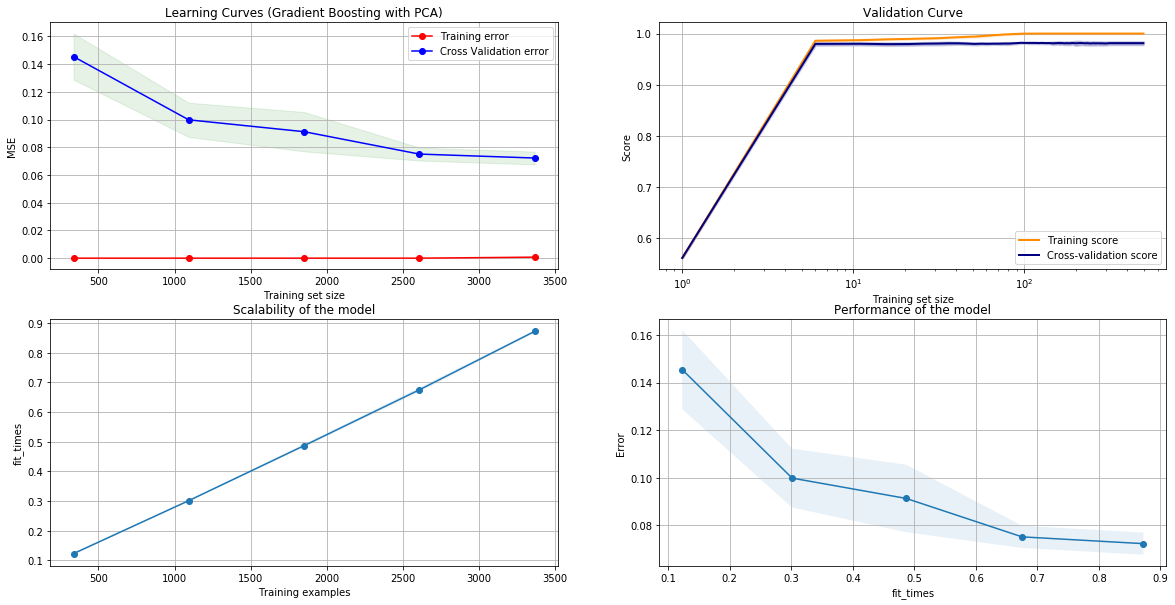

In [33]:
title = r"Learning Curves (Gradient Boosting with PCA)"
fname = "Gradient Boosting with PCA"
plot_learning_curve(clf3, title, X_train, y_train,  ylim=(0.7, 1.01),cv=5, TN=TN,FP=FP,TP=TP,FN=FN,mse=mse,AC = AC,F1=F1,SE=SE,SP=SP,PR=PR,BER=BER,TA=Train_Accuracy,fname=fname)

plt.show()

#### Twin SVM

In [34]:
# Step 1: Load your dataset
data_path = '/home/jakesh/thesis/jaya/final_data.csv'
sep_char = ',' # separtor character of the CSV file
header = True # Whether the dataset has header names.

dataset = DataReader(data_path, sep_char, header)
shuffle_data = True
normalize_data = False

dataset.load_data(shuffle_data, normalize_data)
Xts, yts, file_name = dataset.get_data()
X_traints, X_testts,  y_traints, y_testts = train_test_split(Xts, yts, test_size=0.3, random_state=42)
sc = StandardScaler()
X_traints = sc.fit_transform(X_traints)
X_testts = sc.transform(X_testts)

In [35]:
tsvm_clf = TSVM(kernel='linear')

val = Validator(X_traints, y_traints, ('CV', 5), tsvm_clf) # 5-fold cross-validation
eval_method = val.choose_validator()

# Step 4: Specify range of each hyper-parameter for a TSVM-based estimator.
params = {'C1': (-2, 2), 'C2': (-2, 2), 'gamma': (-10, 2)}

best_acc, best_acc_std, opt_params, clf_results = grid_search(eval_method, params)

print("Best accuracy: %.2f+-%.2f | Optimal parameters: %s" % (best_acc, best_acc_std,
                                                                                  str(opt_params)))

B-Acc:98.67+-0.29|Acc:98.57+-0.29 |#########################| 100.0% Elapsed:0:01:07
Best accuracy: 98.67+-0.29 | Optimal parameters: {'C1': 0.5, 'C2': 4.0, 'gamma': 0.0009765625}


In [36]:
c1 = opt_params['C1']
c2 = opt_params['C2']
gamma = opt_params['gamma']
start = time.time() 
tsvm_clf = TSVM(kernel='linear',C1= c1, C2= c2, gamma= gamma)
tsvm_clf.fit(X_traints,y_traints)
y_pred_test= tsvm_clf.predict(X_testts)
total_time = time.time()-start
y_pred_train= tsvm_clf.predict(X_traints)
mse =mean_squared_error(y_testts, y_pred_test)
Train_Accuracy = accuracy_score(y_traints, y_pred_train)
print('Train Accuracy',Train_Accuracy)
print('Test Accuracy',accuracy_score(y_testts, y_pred_test))
print('Total Time : ',total_time)
print('MSE: ',mse)

Train Accuracy 0.9861864824864331
Test Accuracy 0.9804372842347526
Total Time :  0.03773021697998047
MSE:  0.07825086306098965


In [37]:
TN, FP, FN, TP = confusion_matrix(y_testts,y_pred_test).ravel()
print(TN, FP, FN, TP)
SE = TP/(TP+FN)  #sensitivity, recall, hit rate, or true positive rate (TPR)
SP = TN/(TN+FP)  #specificity, selectivity or true negative rate (TNR)
AC = (TP+TN)/(TP+TN+FP+FN)   #accuracy
PR = TP/(TP+FP)   #precision, positive predictive value (PPV)
BCR = 1/2*(SE+SP)   #balanced classification rate
BER = 1-BCR   #balanced error rate
F1 = 2*PR*SE/(PR+SE)   #F1 score
FNR = 1-SE   #miss rate or false negative rate (FNR)
FPR = 1-SP   #fall-out or false positive rate (FPR)
TS = TP/(TP+FP+FN)   #Threat score (TS) or Critical Success Index (CSI)
DC = 2*TP/(2*TP+FP+FN) #Dice Coefficient
print(AC,F1,TS,DC)

516 6 11 336
0.9804372842347526 0.9753265602322205 0.9518413597733711 0.9753265602322206


0.03773021697998047
[0.00072641 0.02120862 0.02105608 0.09215531 0.02333331]
[0.04444444 0.06387833 0.0637486  0.0522293  0.05330043]
[0.08880618 0.05919115 0.06116645 0.0572207  0.05327008]


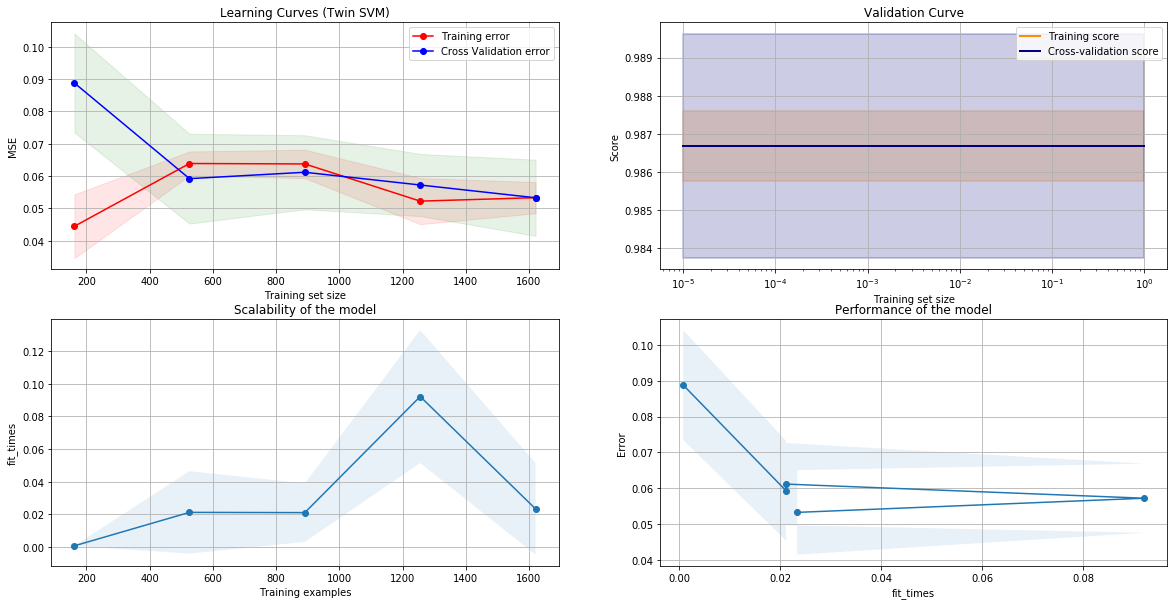

In [38]:
cv=5
title = r"Learning Curves (Twin SVM)"
fname = "Twin SVM"
plot_learning_curve(tsvm_clf, title, X_traints, y_traints,
                    cv=cv, TN=TN,FP=FP,TP=TP,FN=FN,mse=mse,AC = AC,F1=F1,SE=SE,SP=SP,PR=PR,BER=BER,TA=Train_Accuracy,fname=fname)

plt.show()

#### Twin SVM + PCA

In [39]:
pca = PCA(n_components= 4) 
X_traints = pca.fit_transform(X_traints)
X_testts = pca.transform(X_testts)

In [40]:
tsvm_clf1 = TSVM(kernel='linear')

val = Validator(X_traints, y_traints, ('CV', 5), tsvm_clf) # 5-fold cross-validation
eval_method = val.choose_validator()

# Step 4: Specify range of each hyper-parameter for a TSVM-based estimator.
params = {'C1': (-2, 2), 'C2': (-2, 2), 'gamma': (-10, 2)}

best_acc, best_acc_std, opt_params, clf_results = grid_search(eval_method, params)

print("Best accuracy: %.2f+-%.2f | Optimal parameters: %s" % (best_acc, best_acc_std,
                                                                                  str(opt_params)))

B-Acc:98.72+-0.24|Acc:98.52+-0.31 |#########################| 100.0% Elapsed:0:02:09
Best accuracy: 98.72+-0.24 | Optimal parameters: {'C1': 0.25, 'C2': 2.0, 'gamma': 0.0009765625}


In [41]:
c1 = opt_params['C1']
c2 = opt_params['C2']
gamma = opt_params['gamma']
start = time.time() 
tsvm_clf1 = TSVM(kernel='linear',C1= c1, C2= c2, gamma= gamma)
a=tsvm_clf1.fit(X_traints,y_traints)
y_pred_test= tsvm_clf1.predict(X_testts)
total_time = time.time()-start
y_pred_train= tsvm_clf1.predict(X_traints)
mse =mean_squared_error(y_testts, y_pred_test)
Train_Accuracy = accuracy_score(y_traints, y_pred_train)
print('Train Accuracy',Train_Accuracy)
print('Test Accuracy',accuracy_score(y_testts, y_pred_test))
print('Total Time : ',total_time)
print('MSE: ',mse)

Train Accuracy 0.9871731623088308
Test Accuracy 0.9758342922899885
Total Time :  0.03778433799743652
MSE:  0.09666283084004602


In [42]:
TN, FP, FN, TP = confusion_matrix(y_testts,y_pred_test).ravel()
print(TN, FP, FN, TP)
SE = TP/(TP+FN)  #sensitivity, recall, hit rate, or true positive rate (TPR)
SP = TN/(TN+FP)  #specificity, selectivity or true negative rate (TNR)
AC = (TP+TN)/(TP+TN+FP+FN)   #accuracy
PR = TP/(TP+FP)   #precision, positive predictive value (PPV)
BCR = 1/2*(SE+SP)   #balanced classification rate
BER = 1-BCR   #balanced error rate
F1 = 2*PR*SE/(PR+SE)   #F1 score
FNR = 1-SE   #miss rate or false negative rate (FNR)
FPR = 1-SP   #fall-out or false positive rate (FPR)
TS = TP/(TP+FP+FN)   #Threat score (TS) or Critical Success Index (CSI)
DC = 2*TP/(2*TP+FP+FN) #Dice Coefficient
print(AC,F1,TS,DC)

514 8 13 334
0.9758342922899885 0.969521044992743 0.9408450704225352 0.969521044992743


0.03778433799743652
[0.00892186 0.00263119 0.00517154 0.04630651 0.11117668]
[0.08888889 0.06539924 0.05925926 0.05286624 0.05428748]
[0.07499361 0.06314663 0.05525999 0.05328468 0.05328468]


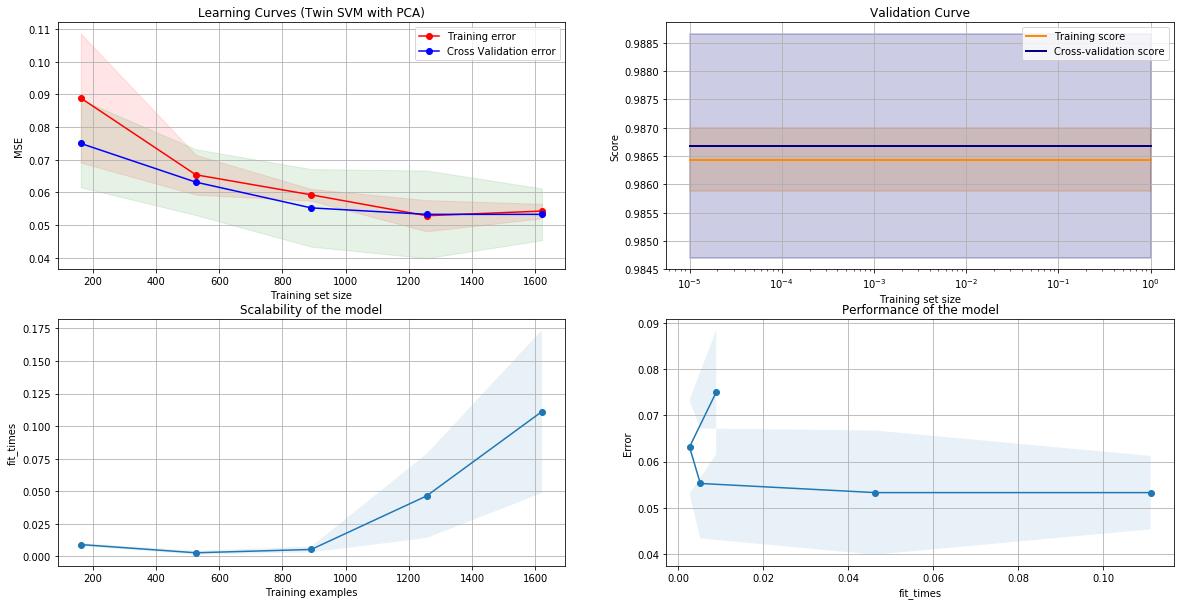

In [43]:
cv=5
title = r"Learning Curves (Twin SVM with PCA)"
fname = "Twin SVM with PCA"
plot_learning_curve(tsvm_clf1, title, X_traints, y_traints,
                    cv=cv, TN=TN,FP=FP,TP=TP,FN=FN,mse=mse,AC = AC,F1=F1,SE=SE,SP=SP,PR=PR,BER=BER,TA=Train_Accuracy,fname=fname)

plt.show()

ROC Plot

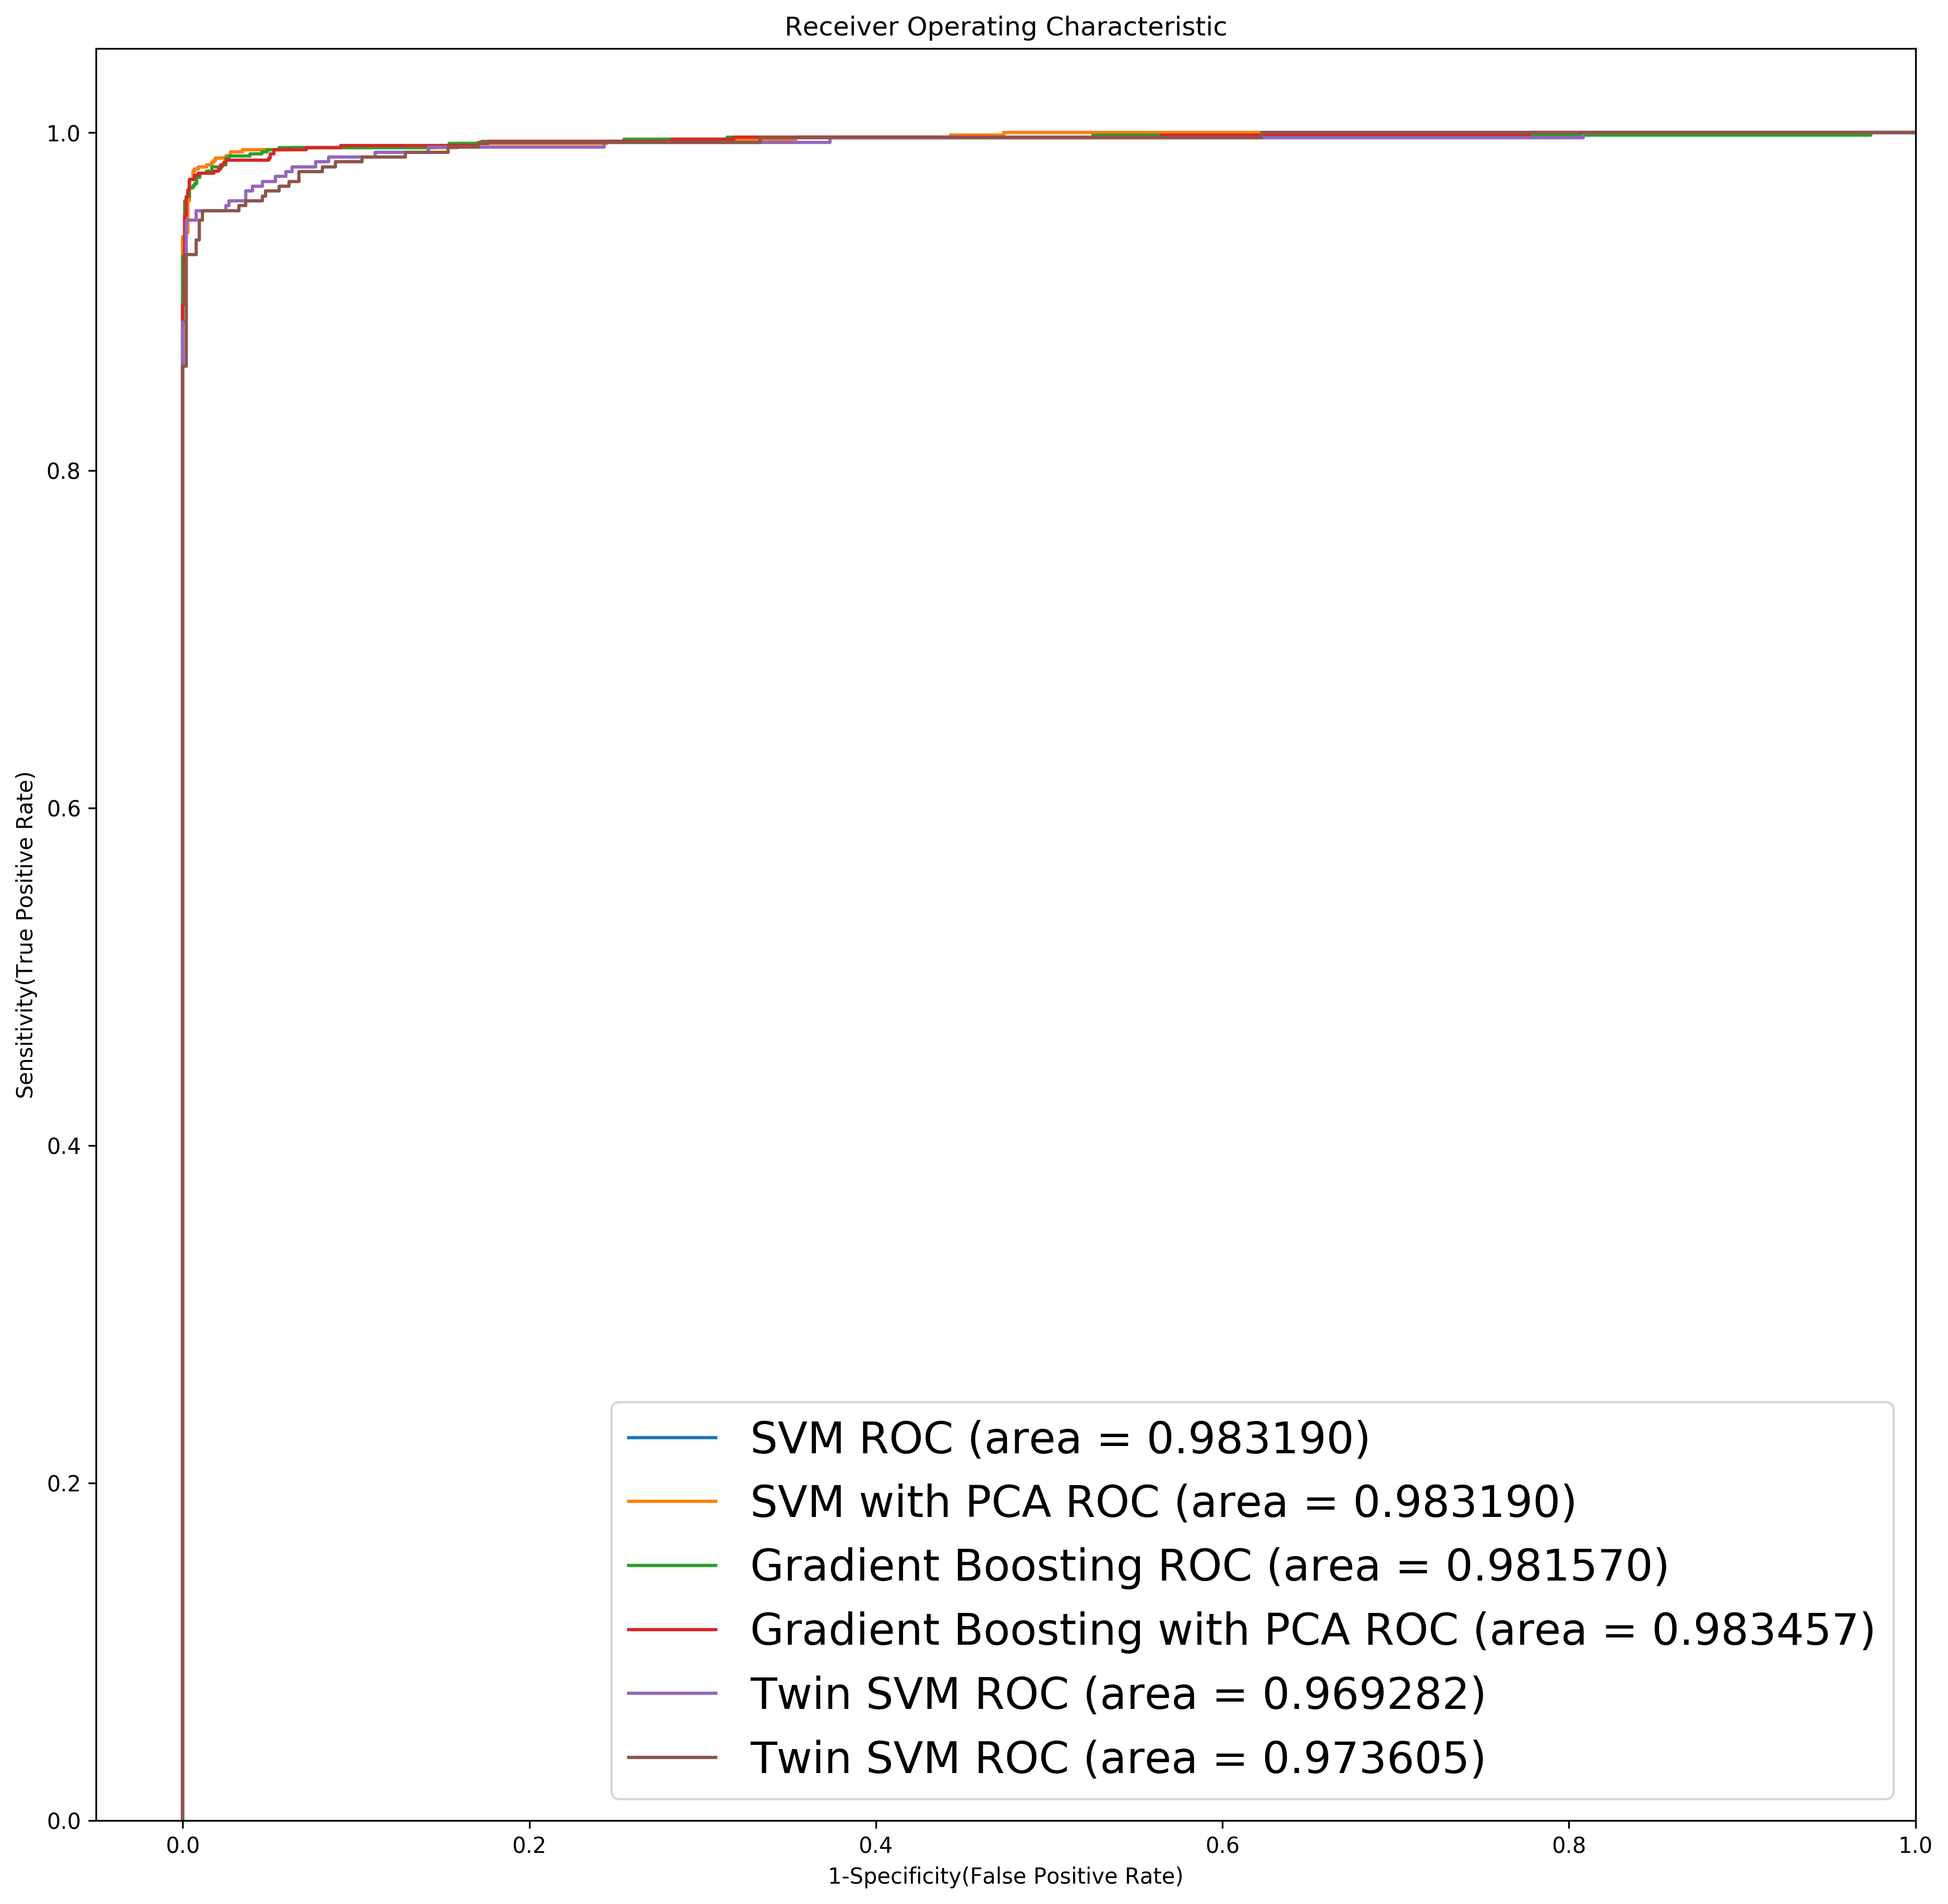

In [44]:
plt.figure(figsize=[15,15], dpi=300)
models = [
    {
    'label': 'SVM',
    'model': clf1,
},
    {
    'label': 'SVM with PCA',
    'model': clf1,
},
{
    'label': 'Gradient Boosting',
    'model': clf2,
},
{
    'label': 'Gradient Boosting with PCA',
    'model': clf3,
},
{
    'label': 'Twin SVM',
    'model': tsvm_clf,
},
{
    'label': 'Twin SVM',
    'model': tsvm_clf1,
}
]
for m in models:
    model = m['model'] 
    
    if model == tsvm_clf or model == tsvm_clf1:
        model.fit(X_traints, y_traints) 
        y_pred=model.predict(X_testts) 
        ax=model.decision_function(X_testts)[::,0]
        nb = normalize([ax])  
        fpr, tpr, thresholds = metrics.roc_curve(y_testts, nb[0]) 
        X_test1 = X_testts
        y_test1 = y_testts
        
    else:
        model.fit(X_train, y_train) 
        y_pred=model.predict(X_test) 
        fpr, tpr, thresholds = metrics.roc_curve(y_test, model.predict_proba(X_test)[:,1])
        X_test1 = X_test
        y_test1 = y_test
    auc = metrics.roc_auc_score(y_test1,model.predict(X_test1))
    plt.plot(fpr, tpr, label='%s ROC (area = %0.6f)' % (m['label'], auc))
# plt.figure(figsize=(15,10))
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right", fontsize=20)
plt.savefig("ROC.png")
plt.show()   # Display

Bar Plot


In [52]:
result = pd.read_csv("result.csv")


In [53]:
result

,Model,TN,FP,FN,TP,Accuracy,Sensitivity,Specificity,Precision,F1_Score,MSE,Error Rate,Training Accuracy,Time
0,SVM,1008,1,12,783,0.992794,0.984906,0.999009,0.998724,0.991767,0.028825,0.008043,0.995247,51.353303
1,SVM with PCA,1003,6,22,773,0.984479,0.972327,0.994054,0.992298,0.982211,0.062084,0.016810,0.986692,3.407520
2,Gradient Boosting,1001,8,23,772,0.982816,0.971069,0.992071,0.989744,0.980317,0.068736,0.018430,1.000000,123.457042
3,Gradient Boosting with PCA,1001,8,20,775,0.984479,0.974843,0.992071,0.989783,0.982256,0.062084,0.016543,0.999525,12.492541
4,Twin SVM,516,6,11,336,0.980437,0.968300,0.988506,0.982456,0.975327,0.078251,0.021597,0.986186,0.847379
5,Twin SVM with PCA,514,8,13,334,0.975834,0.962536,0.984674,0.976608,0.969521,0.096663,0.026395,0.987173,0.913008


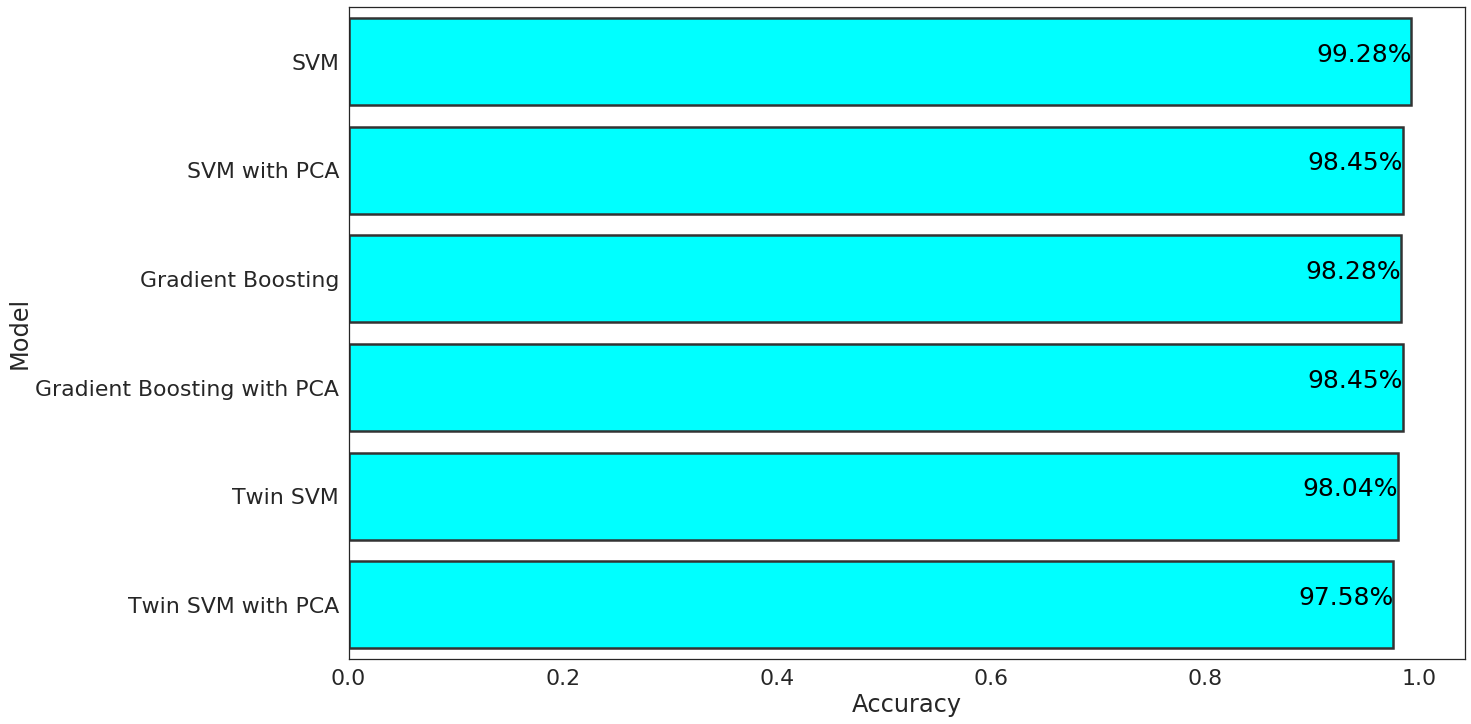

In [54]:
sns.set(rc={'figure.figsize':(20, 12)},font_scale = 2)
sns.set_style("white")
ax = sns.barplot(x=result['Accuracy'], y=result['Model'], data=result, linewidth=2.5,facecolor=[0,1,1,1],
                  edgecolor=".2")
for index, row in result.iterrows():
    ax.text(row.Accuracy,row.name, str(round(row.Accuracy*100,2))+'%', color='black', ha="right", fontsize=25)
ax.figure.savefig("Accuracy Bar Plot.png",bbox_inches='tight')

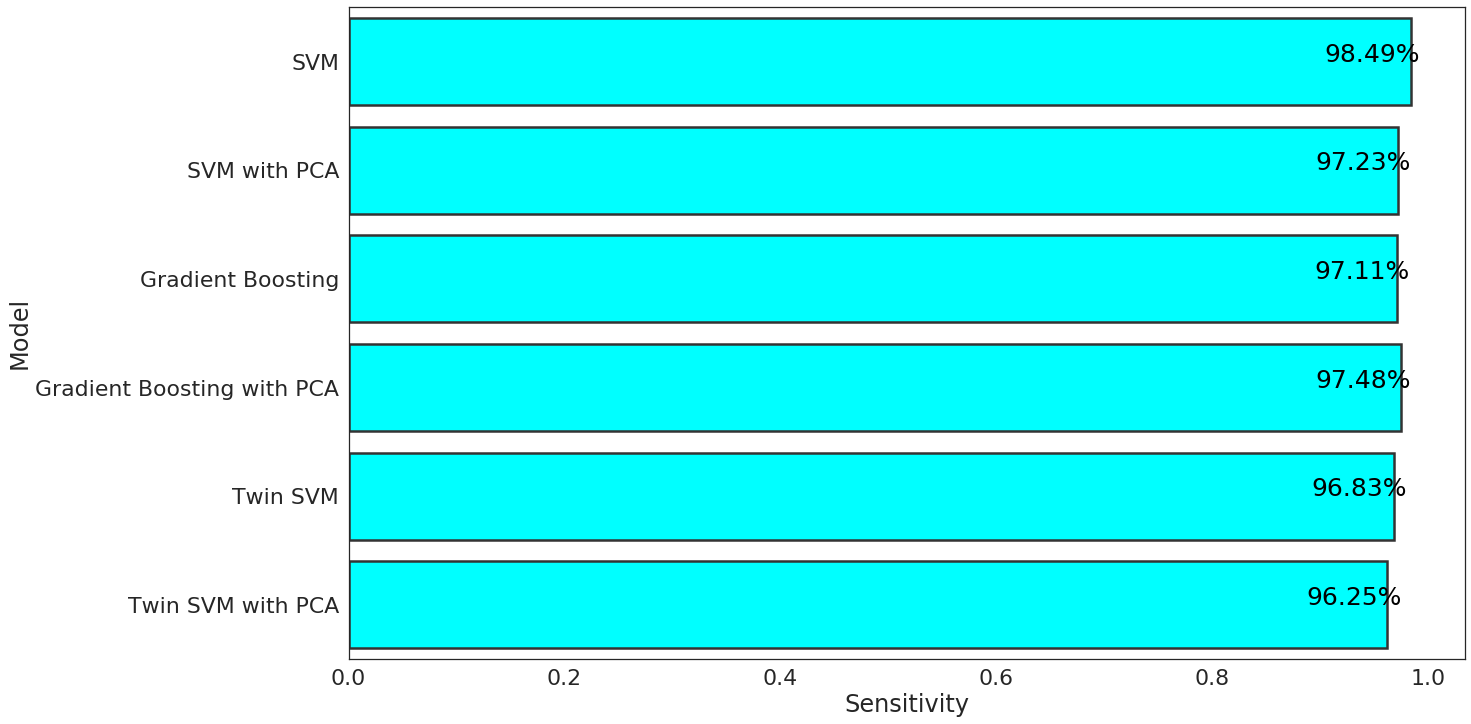

In [55]:
ax = sns.barplot(x=result['Sensitivity'], y=result['Model'], data=result, linewidth=2.5,facecolor=[0,1,1,1],
                  edgecolor=".2")
for index, row in result.iterrows():
    ax.text(row.Accuracy,row.name, str(round(row.Sensitivity*100,2))+'%', color='black', ha="right", fontsize=25)
ax.figure.savefig("Sensitivity Bar Plot.png",bbox_inches='tight')

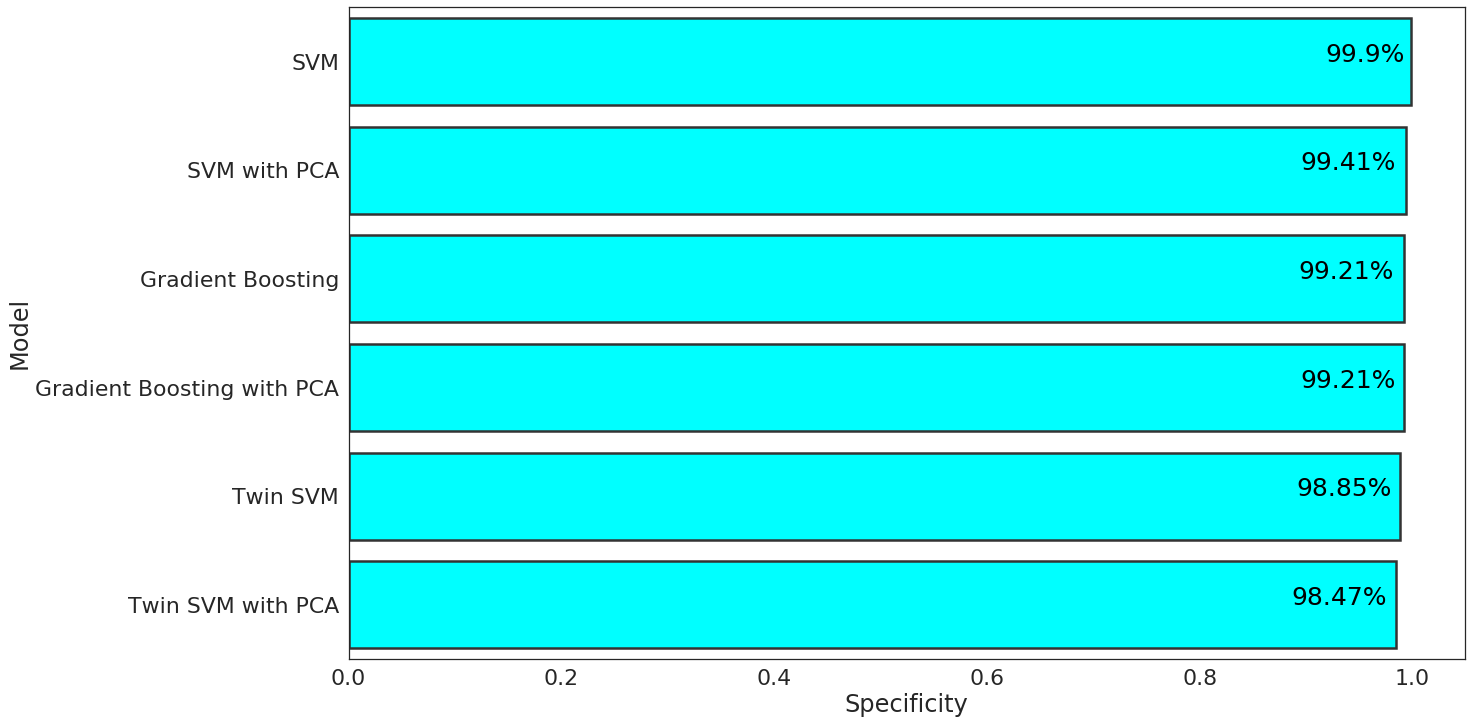

In [56]:
ax = sns.barplot(x=result['Specificity'], y=result['Model'], data=result, linewidth=2.5,facecolor=[0,1,1,1],
                  edgecolor=".2")
for index, row in result.iterrows():
    ax.text(row.Accuracy,row.name, str(round(row.Specificity*100,2))+'%', color='black', ha="right", fontsize=25)
ax.figure.savefig("Specificity Bar Plot.png",bbox_inches='tight')

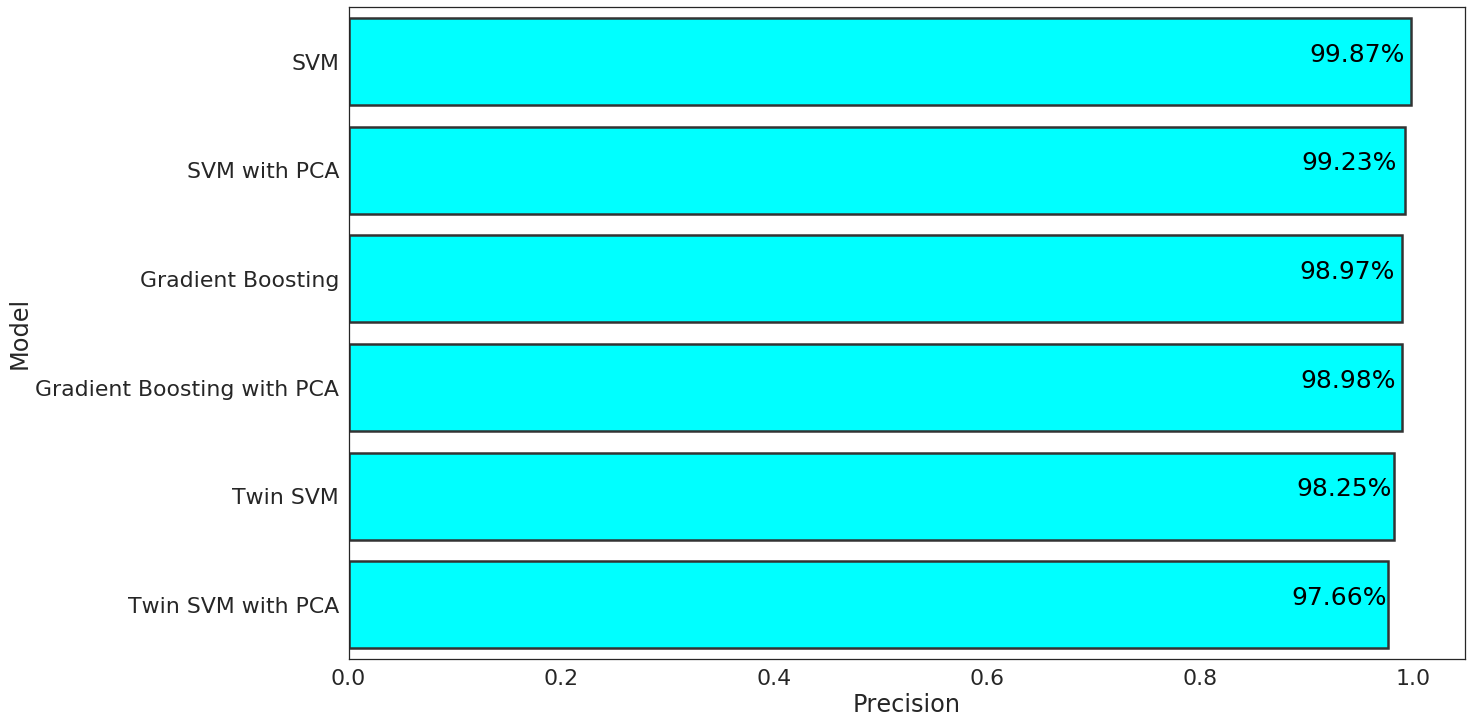

In [57]:
ax = sns.barplot(x=result['Precision'], y=result['Model'], data=result, linewidth=2.5,facecolor=[0,1,1,1],
                  edgecolor=".2")
for index, row in result.iterrows():
    ax.text(row.Accuracy,row.name, str(round(row.Precision*100,2))+'%', color='black', ha="right", fontsize=25)
ax.figure.savefig("Precision Bar Plot.png",bbox_inches='tight')

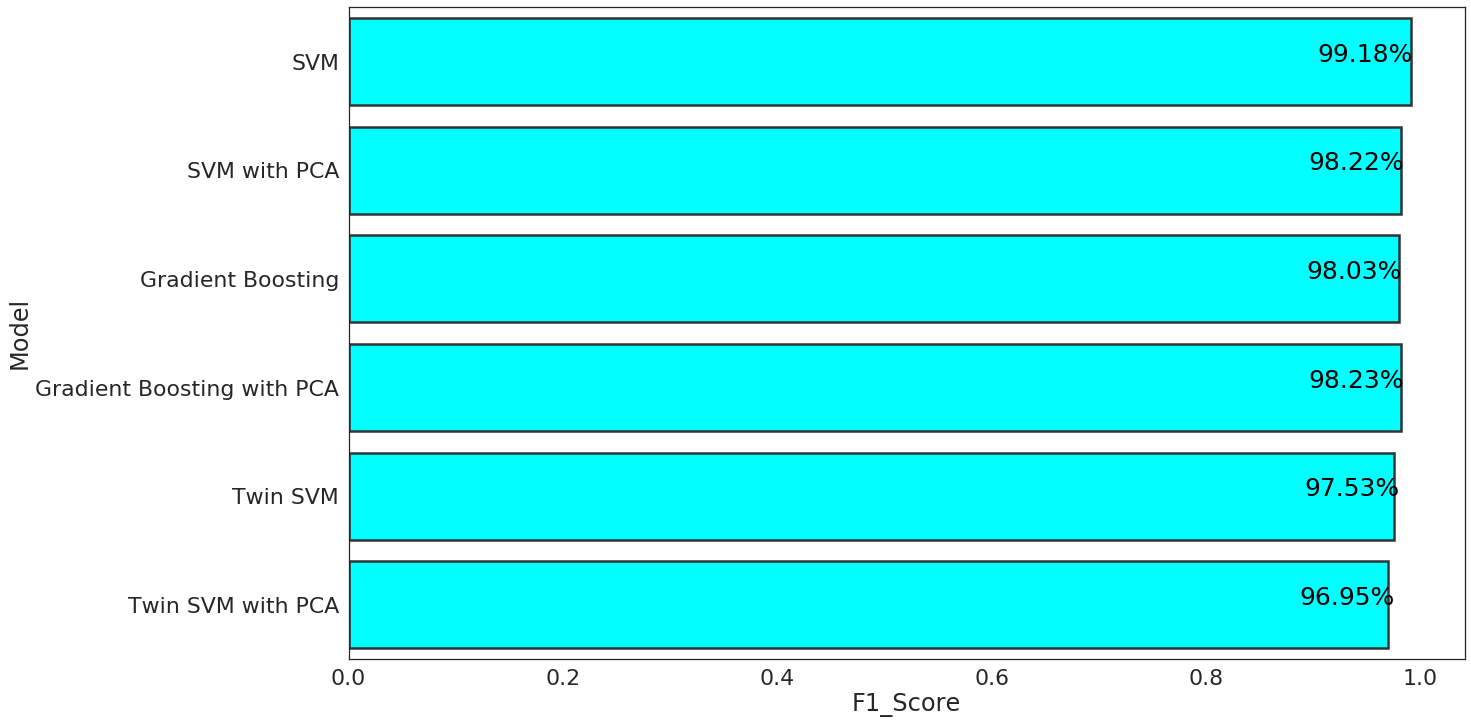

In [58]:
ax = sns.barplot(x=result['F1_Score'], y=result['Model'], data=result, linewidth=2.5,facecolor=[0,1,1,1],
                  edgecolor=".2")
for index, row in result.iterrows():
    ax.text(row.Accuracy,row.name, str(round(row.F1_Score*100,2))+'%', color='black', ha="right", fontsize=25)
ax.figure.savefig("F1-Score Bar Plot.png",bbox_inches='tight')

### 